# Monocular Visual Odometry

## Fundamentals concepts
Source : "Visual Odometry, Part 1: The First 30 years and Fundamentals"

Visual odometry is the process of estimating the egomotion of a vehicle using only cameras. It doesn't focus on global consistency, but rather fast, local estimates that are consistent over short periods of time.


The main task in VO is to compute the relative transformations $T_k$ from the images $I_k$ and $I_{k-1}$ and concatenate the transformations to obtain the full trajectory $C$ of the camera.

There are two main ways of computing the relative motions $T_k$: 
- Appearance-based, using intensity information from all the pixels
- Feature-based, using tracked sailent features

We focus on feature-based methods as the tend to be more efficient.

## Steps 
### Remark on the camera model
We assume pinhole projection system (perspective camera model), and throughout this discussion we assume normalized coordinates, ie $K^{-1} [u,v,1]$ for a given pixel $[u, v]$.

We make the difference between feature matching and tracking.
- matching: we look accross all frames 
- tracking: we follow a feature through consecutive frames

### First and second : detecting and matching / tracking  2D features
We call *image correspondences* 2D features that are the reprojection of the same 3D features accross several frames.

- First possiblity: We detect features in all the images and match them based on some similarity metric.
- Second possiblity: We track features accross the images.

### Third step: motion estimation
We compute the relative motion $T_k$ between time instants $k$ and $k-1$.

Remark: Outliers will greatly disturb motion estimation, therefore the method needs to be robust (don't have wrong data associations).

Let's describe how to compute the transformation $T_k$ betwen two images $I_{k-1}$ and $I_k$ from two sets of matching features $f_{k-1}, f_k$. We consider the 2D to 2D case, ie both feature sets are in 2D image coordinates.

When working in 2D to 2D, it is natural to use the essential matrix $E$. The essential matrix describes the geometric relation between two images of a calibrated camera (up to an unknown scale factor for the translation).
There is a simple way to compute $E$ using 8 pairs of  of non coplanar points (described in another notebook).

### Fourth step: decomposing $E$
From the estimate of $E$, we can decompose the rotation $R$ and translation $t$ of the camera into 4 possible solutions. It is however possible to identify the correct solution by choosing the one that puts points in front of the camera.

Remark: afterwards, a nonlinear optimization of the rotation and translations parameters should be performed, by minimizing the reprojection error, using $R$ and $t$ as initial values.

### Fifth step: computing the relative scale
As we mentioned, we need to concatenate consecutive transformations to compute the full trajectory. While we cannot compute the absolute scale from single views, we can still compute the relative scales between transformations.

To do so, we triangulate 3D points $X_k, X_{k-1}$ from to subsequent image pairs, and determine the relative scale from the distance ratio between a point pair in $X_k$ and a point pair in $X_{k-1}$. Note that this method requires features to be matched accross multiple frames (at least three), so that the point pairs will match.

Another approach would be to use the trifocal constraint.


### Sixth step: concatenating
Finally we can simply concatenate all the transformations $T_k$ to obtain the trajectory $C_k$ by multiplying them together as $C_k - C_{k-1}T_k$.

## Notes
- VO suffers from drift, as small errors are accumulated over time. The drift can be reduced through bundle adjustment over the last few camera poses, or by using external sensors.
- Most VO implementations assume the camera is calibrated.

In [ ]:
# TODO
# Use non linear optimization to improve R and t
# Actually use matching point pairs in the relative scale computation

In [1]:
import numpy as np
import cv2 as cv
from matplotlib import pyplot as plt
from collections import deque
import copy

%matplotlib notebook

In [353]:
# Initialize consts to be used in linear_LS_triangulation()
# Code from https://github.com/Eliasvan/Multiple-Quadrotor-SLAM/blob/master/Work/python_libs/triangulation.py
linear_LS_triangulation_C = -np.eye(2, 3)

def linear_LS_triangulation(u1, P1, u2, P2):
    """
    Linear Least Squares based triangulation.
    Relative speed: 0.1
    
    (u1, P1) is the reference pair containing normalized image coordinates (x, y) and the corresponding camera matrix.
    (u2, P2) is the second pair.
    
    u1 and u2 are matrices: amount of points equals #rows and should be equal for u1 and u2.
    
    The status-vector will be True for all points.
    """
    A = np.zeros((4, 3))
    b = np.zeros((4, 1))
    
    # Create array of triangulated points
    x = np.zeros((3, len(u1)))
    
    # Initialize C matrices
    C1 = np.array(linear_LS_triangulation_C)
    C2 = np.array(linear_LS_triangulation_C)
    
    for i in range(len(u1)):
        # Derivation of matrices A and b:
        # for each camera following equations hold in case of perfect point matches:
        #     u.x * (P[2,:] * x)     =     P[0,:] * x
        #     u.y * (P[2,:] * x)     =     P[1,:] * x
        # and imposing the constraint:
        #     x = [x.x, x.y, x.z, 1]^T
        # yields:
        #     (u.x * P[2, 0:3] - P[0, 0:3]) * [x.x, x.y, x.z]^T     +     (u.x * P[2, 3] - P[0, 3]) * 1     =     0
        #     (u.y * P[2, 0:3] - P[1, 0:3]) * [x.x, x.y, x.z]^T     +     (u.y * P[2, 3] - P[1, 3]) * 1     =     0
        # and since we have to do this for 2 cameras, and since we imposed the constraint,
        # we have to solve 4 equations in 3 unknowns (in LS sense).

        # Build C matrices, to construct A and b in a concise way
        C1[:, 2] = u1[i, :]
        C2[:, 2] = u2[i, :]
        
        # Build A matrix:
        # [
        #     [ u1.x * P1[2,0] - P1[0,0],    u1.x * P1[2,1] - P1[0,1],    u1.x * P1[2,2] - P1[0,2] ],
        #     [ u1.y * P1[2,0] - P1[1,0],    u1.y * P1[2,1] - P1[1,1],    u1.y * P1[2,2] - P1[1,2] ],
        #     [ u2.x * P2[2,0] - P2[0,0],    u2.x * P2[2,1] - P2[0,1],    u2.x * P2[2,2] - P2[0,2] ],
        #     [ u2.y * P2[2,0] - P2[1,0],    u2.y * P2[2,1] - P2[1,1],    u2.y * P2[2,2] - P2[1,2] ]
        # ]
        A[0:2, :] = C1.dot(P1[0:3, 0:3])    # C1 * R1
        A[2:4, :] = C2.dot(P2[0:3, 0:3])    # C2 * R2
        
        # Build b vector:
        # [
        #     [ -(u1.x * P1[2,3] - P1[0,3]) ],
        #     [ -(u1.y * P1[2,3] - P1[1,3]) ],
        #     [ -(u2.x * P2[2,3] - P2[0,3]) ],
        #     [ -(u2.y * P2[2,3] - P2[1,3]) ]
        # ]
        b[0:2, :] = C1.dot(P1[0:3, 3:4])    # C1 * t1
        b[2:4, :] = C2.dot(P2[0:3, 3:4])    # C2 * t2
        b *= -1
        
        # Solve for x vector
        cv.solve(A, b, x[:, i:i+1], cv.DECOMP_SVD)
    
    return x.T.astype(float), np.ones(len(u1), dtype=bool)

In [352]:
cap = cv.VideoCapture('../VisualOdometry/sequence.mp4')
#Intrinsics for the sequence
K = np.array([[782.8852844 ,   0.        , 653.13914244],
               [  0.        , 782.44726988, 339.99522436],
               [  0.        ,   0.        ,   1.        ]])

frame_idx = 0
res = []

img1 = None
img2 = None

# sometimes openCV returns an (Nx3) essential matrix instead of (3x3)
# we consider those "bad E" 
goodE = None 

frame_buffer = deque(maxlen = 2)
tri_points_buffer = deque(maxlen = 2)

while cap.isOpened():
    ret, frame = cap.read()
    #frame = cv.cvtColor(frame, cv.COLOR_BGR2GRAY)
    # if frame is read correctly ret is True
    if not ret:
        print("Can't receive frame (stream end?). Exiting ...")
        break
        
    # Fill a circular buffer
    if len(frame_buffer) < 2:
        frame_buffer.append((frame, frame_idx))
        frame_idx += 1
        continue
         
    img1, i1 = frame_buffer[0]
    img2, i2 = frame_buffer[1]
    
    # First step: feature detection
    print(f"Sift on {i1} - {i2}")
    sift = cv.SIFT_create()
    # find the keypoints and descriptors with SIFT
    kp1, des1 = sift.detectAndCompute(img1,None)
    kp2, des2 = sift.detectAndCompute(img2,None)
    
    # Second step: feature matching
    # FLANN parameters
    FLANN_INDEX_KDTREE = 1
    index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
    search_params = dict(checks=50)
    flann = cv.FlannBasedMatcher(index_params,search_params)
    matches = flann.knnMatch(des1,des2,k=2)
    pts1 = []
    pts2 = []
    # ratio test as per Lowe's paper
    good_matches = []
    
    for i,(m,n) in enumerate(matches):
        if m.distance < 0.9*n.distance:
            pts2.append(kp2[m.trainIdx].pt)
            pts1.append(kp1[m.queryIdx].pt)
            good_matches.append(m)

    pts1 = np.int32(pts1)
    pts2 = np.int32(pts2)
    
    # Third step: computing E
    E, mask = cv.findEssentialMat(pts1,pts2,K,cv.FM_LMEDS)
    
    if E is not None and E.shape == (3, 3):
        goodE = E
    else:
        E = goodE

    # Fourth step: decomposing E
    _, R, t, mask = cv.recoverPose(E, pts1, pts2, K)
    mask = mask.flatten()
    pts1 = pts1[mask!=0]
    pts2 = pts2[mask!=0]

    # Fifth step: triangulating points to recover scale
    # First we need the projection matrices of the two frames (P = K[R|t])
    RT1 = np.concatenate([np.eye(3), [[0],[0],[0]]], axis = -1)
    P = K @ RT1 
    RT2 = np.concatenate([R, t], axis = -1)
    Pp = K @ RT2
    # Then we normalize image coordinates
    pts1 = np.c_[pts1, np.ones(pts1.shape[0])] # make homogeneous
    pts2 = np.c_[pts2, np.ones(pts2.shape[0])]
    pts1 = (np.linalg.inv(K) @ pts1.T).T
    pts2 = (np.linalg.inv(K) @ pts2.T).T
 
    tri, mask = linear_LS_triangulation(pts1[:, 0:2], P, pts2[:, 0:2], Pp)
    tri_points_buffer.append(tri)
    
    # Compute scale. Note that we should be using actual pairs of points
    # Here we try all possible pairs, hoping to find a decent median value...
    # Therefore, points in pp1 and pp2 would need to match, they'd need to be the same size
    # To do so we would need to match 2D points accross tree frames at once.
    if len(tri_points_buffer) == 2:
        pp1 = tri_points_buffer[0]
        pp2 = tri_points_buffer[1]

        limit = min(len(pp1), len(pp2))
        rr = []
        for i in range(limit):
            for j in range(limit):
                a = np.linalg.norm(pp2[i] - pp2[j])
                b = np.linalg.norm(pp1[i] - pp2[j])
                if b != 0:
                    rr.append(a/b)

        s = np.median(rr)
    
    res.append({"E": E, "R": R, "t": t, "s": s, "nbpoints": len(pts1)})
    frame_buffer.append((frame, frame_idx))
    
    frame_idx += 1

Sift on 0 - 1
Sift on 1 - 2
Sift on 2 - 3
Sift on 3 - 4
Sift on 4 - 5
Sift on 5 - 6
Sift on 6 - 7
Sift on 7 - 8
Sift on 8 - 9
Sift on 9 - 10
Sift on 10 - 11
Sift on 11 - 12
Sift on 12 - 13
Sift on 13 - 14
Sift on 14 - 15
Sift on 15 - 16
Sift on 16 - 17
Sift on 17 - 18
Sift on 18 - 19
Sift on 19 - 20
Sift on 20 - 21
Sift on 21 - 22
Sift on 22 - 23
Sift on 23 - 24
Sift on 24 - 25
Sift on 25 - 26
Sift on 26 - 27
Sift on 27 - 28
Sift on 28 - 29
Sift on 29 - 30
Sift on 30 - 31
Sift on 31 - 32
Sift on 32 - 33
Sift on 33 - 34
Sift on 34 - 35
Sift on 35 - 36
Sift on 36 - 37
Sift on 37 - 38
Sift on 38 - 39
Sift on 39 - 40
Sift on 40 - 41
Sift on 41 - 42
Sift on 42 - 43
Sift on 43 - 44
Sift on 44 - 45
Sift on 45 - 46
Sift on 46 - 47
Sift on 47 - 48
Sift on 48 - 49
Sift on 49 - 50
Sift on 50 - 51
Sift on 51 - 52
Sift on 52 - 53
Sift on 53 - 54
Sift on 54 - 55
Sift on 55 - 56
Sift on 56 - 57
Sift on 57 - 58
Sift on 58 - 59
Sift on 59 - 60
Sift on 60 - 61
Sift on 61 - 62
Sift on 62 - 63
Sift on 63 

Sift on 468 - 469
Sift on 469 - 470
Sift on 470 - 471
Sift on 471 - 472
Sift on 472 - 473
Sift on 473 - 474
Sift on 474 - 475
Sift on 475 - 476
Sift on 476 - 477
Sift on 477 - 478
Sift on 478 - 479
Sift on 479 - 480
Sift on 480 - 481
Sift on 481 - 482
Sift on 482 - 483
Sift on 483 - 484
Sift on 484 - 485
Sift on 485 - 486
Sift on 486 - 487
Sift on 487 - 488
Sift on 488 - 489
Sift on 489 - 490
Sift on 490 - 491
Sift on 491 - 492
Sift on 492 - 493
Sift on 493 - 494
Sift on 494 - 495
Sift on 495 - 496
Sift on 496 - 497
Sift on 497 - 498
Sift on 498 - 499
Sift on 499 - 500
Sift on 500 - 501
Sift on 501 - 502
Sift on 502 - 503
Sift on 503 - 504
Sift on 504 - 505
Sift on 505 - 506
Sift on 506 - 507
Sift on 507 - 508
Sift on 508 - 509
Sift on 509 - 510
Sift on 510 - 511
Sift on 511 - 512
Sift on 512 - 513
Sift on 513 - 514
Sift on 514 - 515
Sift on 515 - 516
Sift on 516 - 517
Sift on 517 - 518
Sift on 518 - 519
Sift on 519 - 520
Sift on 520 - 521
Sift on 521 - 522
Sift on 522 - 523
Sift on 52

<IPython.core.display.Javascript object>


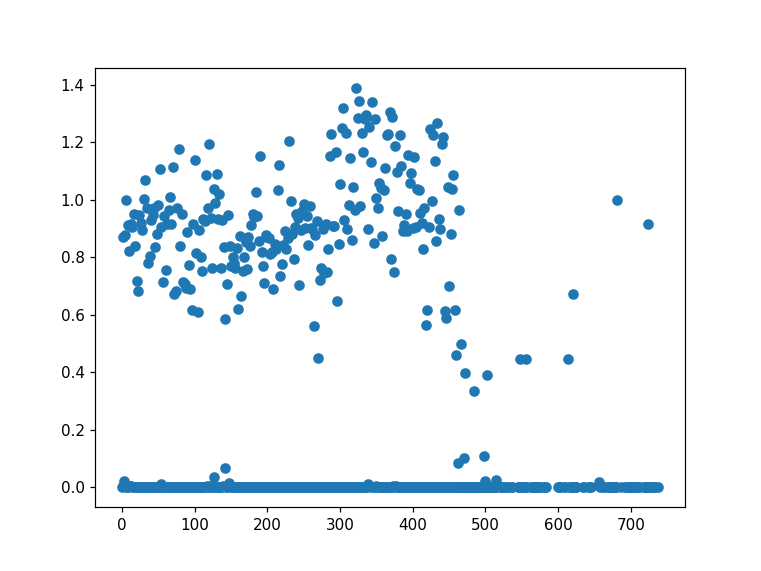

In [354]:
plt.figure()
plt.scatter(x = [x for x in range(len(res))], y = [x["s"] for x in res])
plt.show()

In [355]:
# Sixth step: concatenate the transforms.
C = [np.eye(4)]

for frame in res:
    R = frame["R"]
    t = frame["t"]
    s = frame["s"]
    t_scaled = t * s
    T = np.concatenate([R,t_scaled], axis=-1)
    T = np.concatenate([T, [[0,0,0,1]]], axis = 0)
    C.append((T @ C[-1]).squeeze())
 
# The position of the camera is computed as its global translation from the origin
tg = np.array([(-x[0:3, 0:3].T @ x[0:3, 3].T).squeeze() for x in C])

<IPython.core.display.Javascript object>


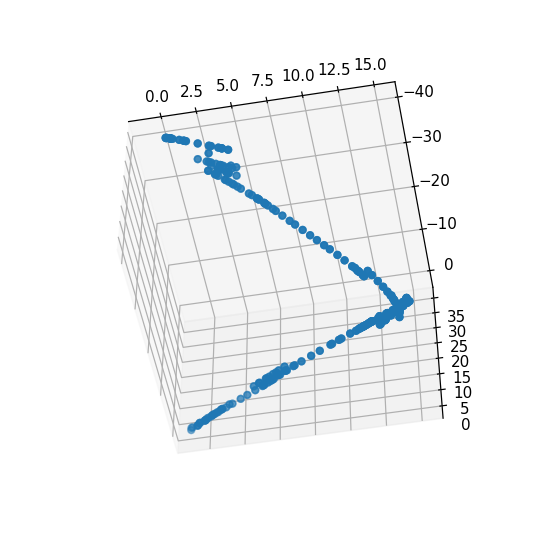

In [356]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(projection='3d')
ax.scatter(tg[:,0], tg[:,1], tg[:, 2])
plt.show()